In [62]:
using PowerSystems
using PowerSimulations
using InfrastructureSystems
using HydroPowerSimulations
const PSI = PowerSimulations
const PSY = PowerSystems
using PowerSystemCaseBuilder
using SiennaPRASInterface
using Dates
using Gurobi, JuMP
using Plots
using CSV, DataFrames, Dates, TimeSeries, DataStructures

In [2]:
sys = build_system(PowerSystemCaseBuilder.SPISystems, "RTS_GMLC_Hourly with Static Outage Data")

┌ Info: Loaded time series from storage file existing=/projects/emco4286/.julia/packages/PowerSystemCaseBuilder/oMfVC/data/serialized_system/e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855/RTS_GMLC_Hourly with Static Outage Data_time_series_storage.h5 new=/projects/emco4286/code-server/tmp/jl_B4A7iE compression=CompressionSettings(false, CompressionTypes.DEFLATE = 1, 3, true)
└ @ InfrastructureSystems /projects/emco4286/.julia/packages/InfrastructureSystems/LEg3t/src/hdf5_time_series_storage.jl:110


Property,Value
Name,
Description,
System Units Base,DEVICE_BASE
Base Power,100.0
Base Frequency,60.0
Num Components,546
Type,Count
ACBus,73
Arc,109
Area,3


In [3]:
rts_outage_ts_data = CSV.read(
        joinpath("/projects", "emco4286", "data", "sienna_data", "RTS_Test_Outage_Time_Series_Data.csv"),
        DataFrame,
    )

Row,Unit,Year Installed,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEPT,OCT,NOV,DEC
,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,101_CT_1,1974,0.385675,0.576425,0.5559,0.49665,0.53655,0.45545,0.38305,0.3105,0.307125,0.245225,0.29935,0.2837
2,101_CT_2,1975,0.274525,0.320075,0.367,0.44565,0.39525,0.3826,0.4584,0.482475,0.402875,0.3666,0.3406,0.295175
3,101_STEAM_3,1999,0.04435,0.077975,0.08335,0.027625,0.0359,0.025525,0.06085,0.060525,0.056675,0.01785,0.05915,0.047975
4,101_STEAM_4,1999,0.096175,0.074625,0.1812,0.0852,0.05065,0.010775,0.1025,0.044675,0.2135,0.01895,0.1873,0.125925
5,102_CT_1,1992,0.04105,0.017025,0.0205,0.12335,0.04765,0.069,0.156225,0.0316,0.0475,0.028375,0.05835,0.076275
6,102_CT_2,1994,0.0125,0.0413,0.047575,0.045625,0.124025,0.148075,0.148825,0.0316,0.013025,0.014375,0.0397,0.0375
7,102_STEAM_3,1993,0.0,0.033775,0.026775,0.01975,0.0079,0.046375,0.061025,0.06165,0.206925,0.051775,0.053075,0.0523
8,102_STEAM_4,1998,0.33225,0.437125,0.4007,0.4292,0.38355,0.342225,0.3672,0.36225,0.375075,0.3803,0.3202,0.23445
9,107_CC_1,1993,0.25425,0.036875,0.107725,0.205425,0.190225,0.3416,0.312175,0.223175,0.024175,0.033475,0.290525,0.2555


In [4]:
# add_timeseries_outage_data!(sys, rts_outage_ts_data)
# UndefVarError: `add_timeseries_outage_data!` not defined

In [5]:
const PSY = PowerSystems
const IS = InfrastructureSystems

function get_ts_timestamps(sys::PSY.System)
    static_ts_summary = PSY.get_static_time_series_summary_table(sys)

    first_timestamp = DateTime(static_ts_summary[1, "initial_timestamp"])
    ts_period = static_ts_summary[1, "resolution"].periods[1]
    ts_resolution = typeof(ts_period)
    ts_step = ts_resolution(ts_period.value)
    ts_count = static_ts_summary[1, "time_step_count"]
    finish_datetime = first_timestamp + ts_resolution((ts_count - 1) * ts_step)

    ts_timestamps = collect(StepRange(first_timestamp, ts_step, finish_datetime))
    return ts_timestamps, first_timestamp, ts_step
end

function rate_to_probability(for_gen::Float64, mttr::Int64)
    if (for_gen > 1.0)
        for_gen = for_gen / 100
    end

    if for_gen == 1.0
        return (λ = 1.0, μ = 0.0)  # can we error here instead?
    end
    if mttr != 0
        μ = 1 / mttr
    else # MTTR of 0.0 doesn't make much sense.
        μ = 1.0
    end
    return (λ = (μ * for_gen) / (1 - for_gen), μ = μ)
end

function add_timeseries_outage_data!(sys::PSY.System, rts_outage_ts_data::DataFrame)
    # Time series timestamps
    ts_timestamps, first_timestamp, step = get_ts_timestamps(sys)

    # Add λ and μ time series 
    for row in DataFrames.eachrow(rts_outage_ts_data)
        comp = PSY.get_component(PSY.Generator, sys, row.Unit)
        λ_vals = Float64[]
        μ_vals = Float64[]
        for i in range(0; length = 12)
            next_timestamp = first_timestamp + Dates.Month(i)
            λ, μ = rate_to_probability(row[3 + i], 48) # Assuming MTTR is 48
            # We have monthly outage rates, so we need to fill in time series based on the 
            # resolution of the SingleTimeSeries
            append!(
                λ_vals,
                fill(λ, (daysinmonth(next_timestamp) * 24 * Int(Dates.Hour(1) / step))),
            )
            append!(
                μ_vals,
                fill(μ, (daysinmonth(next_timestamp) * 24 * Int(Dates.Hour(1) / step))),
            )
        end
        PSY.add_time_series!(
            sys,
            first(
                PSY.get_supplemental_attributes(
                    PSY.GeometricDistributionForcedOutage,
                    comp,
                ),
            ),
            PSY.SingleTimeSeries(
                "outage_probability",
                TimeSeries.TimeArray(ts_timestamps, λ_vals),
            ),
        )
        PSY.add_time_series!(
            sys,
            first(
                PSY.get_supplemental_attributes(
                    PSY.GeometricDistributionForcedOutage,
                    comp,
                ),
            ),
            PSY.SingleTimeSeries(
                "recovery_probability",
                TimeSeries.TimeArray(ts_timestamps, μ_vals),
            ),
        )
        @debug "Added outage probability and recovery probability time series to supplemental attribute of $(row["Unit"]) generator"
    end
end


add_timeseries_outage_data! (generic function with 1 method)

In [6]:
add_timeseries_outage_data!(sys, rts_outage_ts_data)

In [7]:
# 48 hour horizon, 24 hour interval
PSY.transform_single_time_series!(sys, Hour(48), Hour(24))

template_uc = template_unit_commitment(network=NetworkModel(CopperPlatePowerModel, use_slacks = true))

solver = optimizer_with_attributes(Gurobi.Optimizer)
set_optimizer_attribute(solver, "MIPGap", 0.5)

problem = DecisionModel(template_uc, sys; optimizer = solver, name = "UC")

Network Model
┌───────────────┬───────────────────────┐
│ Network Model │ CopperPlatePowerModel │
│ Slacks        │ true                  │
│ PTDF          │ false                 │
│ Duals         │ None                  │
└───────────────┴───────────────────────┘

Device Models
┌────────────────────────┬────────────────────────────┬────────┐
│ Device Type            │ Formulation                │ Slacks │
├────────────────────────┼────────────────────────────┼────────┤
│ RenewableNonDispatch   │ FixedOutput                │ false  │
│ ThermalStandard        │ ThermalBasicUnitCommitment │ false  │
│ PowerLoad              │ StaticPowerLoad            │ false  │
│ InterruptiblePowerLoad │ PowerLoadInterruption      │ false  │
│ RenewableDispatch      │ RenewableFullDispatch      │ false  │
└────────────────────────┴────────────────────────────┴────────┘

Branch Models
┌─────────────────────┬─────────────────────────┬────────┐
│ Branch Type         │ Formulation             │ Slacks │
├─────────────────────┼─────────────────────────┼────────┤
│ Line                │ StaticBranch            │ false  │
│ TapTransformer      │ StaticBranch            │ false  │
│ Transformer2W       │ StaticBranch            │ false  │
│ TwoTerminalHVDCLine │ HVDCTwoTerminalDispatch │ false  │
└─────────────────────┴─────────────────────────┴────────┘

Service Models
┌────────────┬──────────────────────────────┬──────────────┬────────┬───────────
│ Name       │ Service Type                 │ Formulation  │ Slacks │ Aggregat ⋯
├────────────┼──────────────────────────────┼──────────────┼────────┼───────────
│ Reg_Down   │ VariableReserve{ReserveDown} │ RangeReserve │ false  │ false    ⋯
│ Spin_Up_R1 │ VariableReserve{ReserveUp}   │ RangeReserve │ false  │ false    ⋯
│ Reg_Up     │ VariableReserve{ReserveUp}   │ RangeReserve │ false  │ false    ⋯
│ Flex_Up    │ VariableReserve{ReserveUp}   │ RangeReserve │ false  │ false    ⋯
│ Spin_Up_R2 │ VariableReserve{ReserveUp}   │ RangeReserve │ false  │ false    ⋯
│ Flex_Down  │ VariableReserve{ReserveDown} │ RangeReserve │ false  │ false    ⋯
│ Spin_Up_R3 │ VariableReserve{ReserveUp}   │ RangeReserve │ false  │ false    ⋯
└────────────┴──────────────────────────────┴──────────────┴────────┴───────────
                                                                1 column omitted

In [8]:

models = SimulationModels(;
    decision_models = [problem],
)

sequence = SimulationSequence(;
    models = models,
    ini_cond_chronology = InterProblemChronology(),
)

output_dir = joinpath("/projects", "emco4286", "data", "sienna_data", "output", "test", "uc_only")

sim = Simulation(;
    name = "outages",
    steps = 1,
    models = models,
    sequence = sequence,
    simulation_folder = output_dir,
)

build!(sim)
execute!(sim)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2682251
Academic license 2682251 - for non-commercial use only - registered to em___@colorado.edu
Set parameter MIPGap to value 0.5


┌ Info: 
│ ────────────────────────────────────────────────────────────────────────────────────────────
│                                                    Time                    Allocations      
│                                           ───────────────────────   ────────────────────────
│             Tot / % measured:                  46.1s /  99.8%           3.47GiB / 100.0%    
│ 
│ Section                           ncalls     time    %tot     avg     alloc    %tot      avg
│ ────────────────────────────────────────────────────────────────────────────────────────────
│ Build Simulation                       1    46.0s  100.0%   46.0s   3.47GiB  100.0%  3.47GiB
│   Build Decision Problems              1    28.1s   61.1%   28.1s   2.40GiB   69.0%  2.40GiB
│     Problem UC                         1    28.1s   61.1%   28.1s   2.40GiB   69.0%  2.40GiB
│       ThermalStandard                  2    5.68s   12.3%   2.84s    563MiB   15.8%   282MiB
│       RenewableNonDispatch          

InfrastructureSystems.Simulation.RunStatusModule.RunStatus.SUCCESSFULLY_FINALIZED = 0

In [9]:
solutions = SimulationResults("/projects/emco4286/data/sienna_data/output/test/uc_only", "outages")

┌ Info: Loading simulation results from /projects/emco4286/data/sienna_data/output/test/uc_only/outages-3
└ @ PowerSimulations /projects/emco4286/.julia/packages/PowerSimulations/89s3Q/src/simulation/simulation_results.jl:87
┌ Info: checking integrity of simulation_store.h5
└ @ PowerSimulations /projects/emco4286/.julia/packages/PowerSimulations/89s3Q/src/utils/file_utils.jl:53


Decision Problem Results
┌──────────────┬─────────────────────┬────────────┬─────────────────────────┐
│ Problem Name │ Initial Time        │ Resolution │ Last Solution Timestamp │
├──────────────┼─────────────────────┼────────────┼─────────────────────────┤
│ UC           │ 2020-01-01T00:00:00 │ 1 hour     │ 2020-01-01T00:00:00     │
└──────────────┴─────────────────────┴────────────┴─────────────────────────┘

Emulator Results
┌─────────────────┬────────────┐
│ Name            │ Emulator   │
│ Resolution      │ 60 minutes │
│ Number of steps │ 24         │
└─────────────────┴────────────┘

In [10]:
results_uc = get_decision_problem_results(solutions, "UC")

ActivePowerBalance__System
FuelConsumptionExpression__ThermalStandard
ProductionCostExpression__RenewableDispatch
ProductionCostExpression__ThermalStandard
ActivePowerTimeSeriesParameter__PowerLoad
ActivePowerTimeSeriesParameter__RenewableNonDispatch
RequirementTimeSeriesParameter__VariableReserve__ReserveDown__Reg_Down
RequirementTimeSeriesParameter__VariableReserve__ReserveUp__Spin_Up_R1
RequirementTimeSeriesParameter__VariableReserve__ReserveUp__Reg_Up
RequirementTimeSeriesParameter__VariableReserve__ReserveUp__Flex_Up
RequirementTimeSeriesParameter__VariableReserve__ReserveUp__Spin_Up_R2


In [12]:
ren_disp = read_variable(results_uc, "OnVariable__ThermalStandard")

SortedDict{Any, Any, Base.Order.ForwardOrdering} with 1 entry:
  DateTime("2020-01-01T00:00:00") => 48×77 DataFrame…

In [13]:
# result_keys = keys(ren_disp)

In [14]:
data = getindex(ren_disp, collect(keys(ren_disp))[1])

Row,DateTime,322_CT_6,321_CC_1,202_STEAM_3,315_STEAM_1,223_CT_4,123_STEAM_2,213_CT_1,223_CT_6,313_CC_1,202_CT_2,101_STEAM_3,302_CT_1,123_CT_1,113_CT_3,302_CT_3,215_CT_4,102_STEAM_3,301_CT_4,202_CT_1,113_CT_2,221_CC_1,223_CT_5,315_CT_7,215_CT_5,114_SYNC_COND_1,323_CC_1,101_STEAM_4,113_CT_1,223_STEAM_3,318_CC_1,307_CT_2,213_CT_2,113_CT_4,315_STEAM_3,118_CC_1,315_CT_8,302_CT_2,218_CC_1,213_CC_3,115_STEAM_3,323_CC_2,101_CT_1,115_STEAM_2,314_SYNC_COND_1,101_CT_2,322_CT_5,214_SYNC_COND_1,315_STEAM_5,207_CT_2,123_STEAM_3,223_STEAM_1,123_CT_5,301_CT_1,223_STEAM_2,202_STEAM_4,116_STEAM_1,315_STEAM_4,115_STEAM_1,315_STEAM_2,121_NUCLEAR_1,102_CT_2,123_CT_4,207_CT_1,301_CT_3,316_STEAM_1,102_CT_1,216_STEAM_1,315_CT_6,201_CT_2,201_STEAM_3,201_CT_1,301_CT_2,302_CT_4,307_CT_1,102_STEAM_4,107_CC_1
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-01-01T00:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
2,2020-01-01T01:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
3,2020-01-01T02:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
4,2020-01-01T03:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
5,2020-01-01T04:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
6,2020-01-01T05:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
7,2020-01-01T06:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0

In [58]:
data

Row,DateTime,322_CT_6,321_CC_1,202_STEAM_3,315_STEAM_1,223_CT_4,123_STEAM_2,213_CT_1,223_CT_6,313_CC_1,202_CT_2,101_STEAM_3,302_CT_1,123_CT_1,113_CT_3,302_CT_3,215_CT_4,102_STEAM_3,301_CT_4,202_CT_1,113_CT_2,221_CC_1,223_CT_5,315_CT_7,215_CT_5,114_SYNC_COND_1,323_CC_1,101_STEAM_4,113_CT_1,223_STEAM_3,318_CC_1,307_CT_2,213_CT_2,113_CT_4,315_STEAM_3,118_CC_1,315_CT_8,302_CT_2,218_CC_1,213_CC_3,115_STEAM_3,323_CC_2,101_CT_1,115_STEAM_2,314_SYNC_COND_1,101_CT_2,322_CT_5,214_SYNC_COND_1,315_STEAM_5,207_CT_2,123_STEAM_3,223_STEAM_1,123_CT_5,301_CT_1,223_STEAM_2,202_STEAM_4,116_STEAM_1,315_STEAM_4,115_STEAM_1,315_STEAM_2,121_NUCLEAR_1,102_CT_2,123_CT_4,207_CT_1,301_CT_3,316_STEAM_1,102_CT_1,216_STEAM_1,315_CT_6,201_CT_2,201_STEAM_3,201_CT_1,301_CT_2,302_CT_4,307_CT_1,102_STEAM_4,107_CC_1
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-01-01T00:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
2,2020-01-01T01:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
3,2020-01-01T02:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
4,2020-01-01T03:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
5,2020-01-01T04:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
6,2020-01-01T05:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
7,2020-01-01T06:00:00,-0.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,1.0,1.0,-0.0,-0.0,-0

In [11]:
component = get_component(ThermalStandard, sys,  "101_CT_1")

ThermalStandard: 101_CT_1:
   name: 101_CT_1
   available: true
   status: true
   bus: ACBus: Abel
   active_power: 0.07999999999999999
   reactive_power: 0.0496
   rating: 0.223606797749979
   active_power_limits: (min = 0.07999999999999999, max = 0.2)
   reactive_power_limits: (min = 0.0, max = 0.1)
   ramp_limits: (up = 0.03, down = 0.03)
   operation_cost: ThermalGenerationCost composed of variable: FuelCurve{PiecewiseIncrementalCurve}
   base_power: 24.0
   time_limits: (up = 1.0, down = 1.0)
   must_run: false
   prime_mover_type: PrimeMovers.CT = 8
   fuel: ThermalFuels.DISTILLATE_FUEL_OIL = 3
   services: 5-element Vector{Service}
   time_at_status: 10000.0
   dynamic_injector: nothing
   ext: Dict{String, Any}()
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.SYSTEM_BASE = 0
   has_supplemental_attributes: true
   has_time_series: false

In [21]:
# mgr = component.internal.shared_system_references.time_series_manager
# mgr.data_store
# mgr.metadata_store

InfrastructureSystems.Hdf5TimeSeriesStorage("/projects/emco4286/code-server/tmp/jl_B4A7iE", CompressionSettings(false, CompressionTypes.DEFLATE = 1, 3, true), nothing)

In [43]:
sup_attr = first(PSY.get_supplemental_attributes(PSY.GeometricDistributionForcedOutage, component))

GeometricDistributionForcedOutage: 5ed688b5-7576-4384-8254-20f1635a2efb:
   mean_time_to_recovery: 50.0
   outage_transition_probability: 0.0022222222222222222
   has_time_series: true

In [49]:
# IS.list_metadata(mgr, first(PSY.get_supplemental_attributes(PSY.GeometricDistributionForcedOutage, component)), SingleTimeSeries, "outage_probability")

In [50]:
# IS.list_metadata(mgr, component, SingleTimeSeries, "outage_probability")

In [57]:
# IS.get_time_series_values(SingleTimeSeries, component, "outage_probability")
data = IS.get_time_series_values(SingleTimeSeries, sup_attr, "outage_probability")

8784-element Vector{Float64}:
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 0.013079226522334812
 ⋮
 0.008251314626087766
 0.008251314626087766
 0.008251314626087766
 0.008251314626087766
 0.008251314626087766
 0.008251314626087766
 0.008251314626087766
 0.008251314626087766
 0.008251314626087766

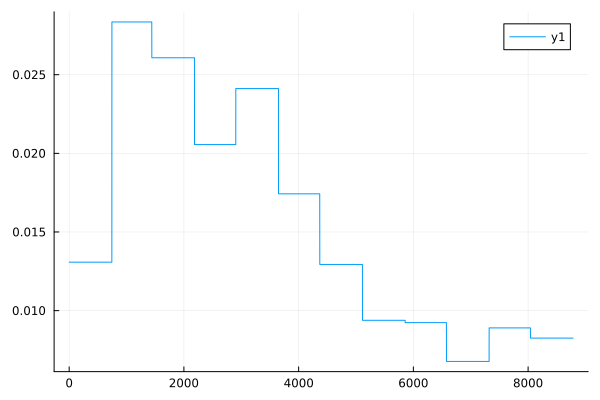

In [58]:
plot(data)

In [45]:
# IS.get_time_series_array(SingleTimeSeries, component, "outage_probability")
IS.get_time_series_array(SingleTimeSeries, sup_attr, "outage_probability")

8784×1 TimeArray{Float64, 1, DateTime, Vector{Float64}} 2020-01-01T00:00:00 to 2020-12-31T23:00:00
┌─────────────────────┬────────────┐
│                     │ A          │
├─────────────────────┼────────────┤
│ 2020-01-01T00:00:00 │  0.0130792 │
│ 2020-01-01T01:00:00 │  0.0130792 │
│ 2020-01-01T02:00:00 │  0.0130792 │
│ 2020-01-01T03:00:00 │  0.0130792 │
│ 2020-01-01T04:00:00 │  0.0130792 │
│ 2020-01-01T05:00:00 │  0.0130792 │
│ 2020-01-01T06:00:00 │  0.0130792 │
│ 2020-01-01T07:00:00 │  0.0130792 │
│          ⋮          │     ⋮      │
│ 2020-12-31T17:00:00 │ 0.00825131 │
│ 2020-12-31T18:00:00 │ 0.00825131 │
│ 2020-12-31T19:00:00 │ 0.00825131 │
│ 2020-12-31T20:00:00 │ 0.00825131 │
│ 2020-12-31T21:00:00 │ 0.00825131 │
│ 2020-12-31T22:00:00 │ 0.00825131 │
│ 2020-12-31T23:00:00 │ 0.00825131 │
└─────────────────────┴────────────┘
                   8769 rows omitted

In [54]:
collect(get_time_series_multiple(sup_attr))

2-element Vector{Any}:
 SingleTimeSeries("outage_probability", 8784×1 TimeArray{Float64, 1, DateTime, Vector{Float64}} 2020-01-01T00:00:00 to 2020-12-31T23:00:00, Millisecond(3600000), nothing, InfrastructureSystems.InfrastructureSystemsInternal(UUID("1bdfaacc-3fbc-48d4-aadc-0017f1d2f64c"), nothing, nothing, nothing))
 SingleTimeSeries("recovery_probability", 8784×1 TimeArray{Float64, 1, DateTime, Vector{Float64}} 2020-01-01T00:00:00 to 2020-12-31T23:00:00, Millisecond(3600000), nothing, InfrastructureSystems.InfrastructureSystemsInternal(UUID("ce409353-6aaa-40fb-90af-f2ef5532af4d"), nothing, nothing, nothing))

In [55]:
IS.get_time_series_metadata(SingleTimeSeries, sup_attr, "outage_probability")

InfrastructureSystems.SingleTimeSeriesMetadata("outage_probability", Millisecond(3600000), DateTime("2020-01-01T00:00:00"), UUID("1bdfaacc-3fbc-48d4-aadc-0017f1d2f64c"), 8784, nothing, Dict{String, Union{Bool, Int64, String}}(), InfrastructureSystems.InfrastructureSystemsInternal(UUID("f6f83525-ecf7-4d11-8c57-9cd07962c44f"), nothing, nothing, nothing))

In [66]:
device_models = SiennaPRASInterface.DeviceRAModel[
        DeviceRAModel(PSY.ThermalStandard, GeneratorPRAS),
        DeviceRAModel(
            PSY.RenewableDispatch,
            GeneratorPRAS(lump_renewable_generation=false),
        ),
    ]
ra_template = SiennaPRASInterface.RATemplate(PSY.Area, device_models)
generate_outage_profile!(sys, SiennaPRASInterface.SequentialMonteCarlo(samples=10, seed=1))

┌ Info: Unit System changed to UnitSystem.NATURAL_UNITS = 2
└ @ PowerSystems /projects/emco4286/.julia/packages/PowerSystems/AHyDB/src/base.jl:552
┌ Info: The first timestamp of PRAS System being built is : 2020-01-01T00:00:00+00:00 and last timestamp is : 2020-12-31T23:00:00+00:00 
└ @ SiennaPRASInterface /projects/emco4286/.julia/packages/SiennaPRASInterface/AECs7/src/PowerSystems2PRAS.jl:830
┌ Info: Processing Area objects in Sienna/Data PowerSystems System... 
└ @ SiennaPRASInterface /projects/emco4286/.julia/packages/SiennaPRASInterface/AECs7/src/PowerSystems2PRAS.jl:847
┌ Info: The Sienna/Data PowerSystems System has 3 regions based on PSY AggregationTopology : Area.
└ @ SiennaPRASInterface /projects/emco4286/.julia/packages/SiennaPRASInterface/AECs7/src/PowerSystems2PRAS.jl:850
┌ Info: Processing Generators in PSY System... 
└ @ SiennaPRASInterface /projects/emco4286/.julia/packages/SiennaPRASInterface/AECs7/src/PowerSystems2PRAS.jl:862
┌ Info: Processing Storages in PSY System.

Property,Value
Name,
Description,
System Units Base,NATURAL_UNITS
Base Power,100.0
Base Frequency,60.0
Num Components,546
Type,Count
ACBus,73
Arc,109
Area,3


In [76]:
ts = get_supplemental_attributes(component)[2]
# IS.get_time_series_keys(SingleTimeSeries, ts)

TimeSeriesForcedOutage: 6f28100c-cb56-4d58-91b6-e995a872a199:
   outage_status_scenario: WorstShortfallSample
   has_time_series: true

In [85]:
collect(get_time_series_multiple(ts))

1-element Vector{Any}:
 SingleTimeSeries("availability", 8784×1 TimeArray{Bool, 1, DateTime, Vector{Bool}} 2020-01-01T00:00:00 to 2020-12-31T23:00:00, Millisecond(3600000), nothing, InfrastructureSystems.InfrastructureSystemsInternal(UUID("e7e61965-f3f9-4089-830b-e15f59821ee1"), nothing, nothing, nothing))

In [86]:
get_time_series_array(SingleTimeSeries, ts, "availability")

8784×1 TimeArray{Bool, 1, DateTime, Vector{Bool}} 2020-01-01T00:00:00 to 2020-12-31T23:00:00
┌─────────────────────┬───────┐
│                     │ A     │
├─────────────────────┼───────┤
│ 2020-01-01T00:00:00 │ false │
│ 2020-01-01T01:00:00 │ false │
│ 2020-01-01T02:00:00 │ false │
│ 2020-01-01T03:00:00 │ false │
│ 2020-01-01T04:00:00 │ false │
│ 2020-01-01T05:00:00 │ false │
│ 2020-01-01T06:00:00 │ false │
│ 2020-01-01T07:00:00 │ false │
│          ⋮          │   ⋮   │
│ 2020-12-31T17:00:00 │ false │
│ 2020-12-31T18:00:00 │ false │
│ 2020-12-31T19:00:00 │  true │
│ 2020-12-31T20:00:00 │  true │
│ 2020-12-31T21:00:00 │  true │
│ 2020-12-31T22:00:00 │  true │
│ 2020-12-31T23:00:00 │  true │
└─────────────────────┴───────┘
              8769 rows omitted

In [56]:
# IS.get_time_series_uuid(SingleTimeSeries, component, "outage_probability")

In [10]:
# get_time_series_array(SingleTimeSeries, component, "outage_probability")
# ArgumentError: No matching metadata is stored.

In [11]:
# sup_attr = IS.get_supplemental_attributes(component)[1]
# ts_keys = get_time_series_keys(sup_attr)
# get_time_series(component, ts_keys[1])
# ArgumentError: No matching metadata is stored.

In [51]:
# forced_outages = collect(get_supplemental_attributes(GeometricDistributionForcedOutage, sys))
# get_supplemental_attribute(sys, IS.get_uuid(forced_outages[1]))

In [52]:
# ts_keys = get_time_series_keys(sup_attr)
# get_time_series_type(ts_keys[1])

In [17]:
# get_time_series(component, SingleTimeSeries)
# MethodError: no method matching get_time_series(::Type{SingleTimeSeries}, ::GeometricDistributionForcedOutage)

In [18]:
# IS.get_store_container_type(ts_keys[1])
# IS.get_time_series_container(component)
# component.time_series_container
# UndefVarError: `get_store_container_type` not defined

In [53]:
# internal = component.internal
# refs = internal.shared_system_references

# IS.InfrastructureSystemsInternal(;
#         uuid = deepcopy(internal.uuid),
#         units_info = deepcopy(internal.units_info),
#         shared_system_references = IS.SharedSystemReferences(;
#         supplemental_attribute_manager = refs.supplemental_attribute_manager, time_series_manager = refs.time_series_manager,
#         ), ext = deepcopy(internal.ext),
#         )